In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch, torch_geometric
import wandb
import utils
from IPython.display import clear_output
import json
import math

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import itertools

In [837]:
def get_model_type(x):
    if isinstance(x, str) and x.startswith("1WL+NN:GIN"): return "1-WL+NN:GNN"
    elif isinstance(x, str) and x.startswith("1WL+NN:GCN"): return "1-WL+NN:GNN"
    elif isinstance(x, str) and x.startswith("1WL+NN:GAT"): return "1-WL+NN:GNN"
    elif isinstance(x, str) and x.startswith("1WL+NN"): return "1-WL+NN"
    elif isinstance(x, str) and (x.startswith("GAT") or x.startswith("GIN") or x.startswith("GCN")): return "GNN"
    else: return pd.NA

def get_pool_type(x):
    if isinstance(x, str) and x.endswith("Embedding-Sum"): return "Embedding:Sum"
    elif isinstance(x, str) and x.endswith("Embedding-Max"): return "Embedding:Max"
    elif isinstance(x, str) and x.endswith("Embedding-Mean"): return "Embedding:Mean"
    elif isinstance(x, str) and x.endswith("Mean"): return "Mean"
    elif isinstance(x, str) and x.endswith("Sum"): return "Sum"
    elif isinstance(x, str) and x.endswith("Max"): return "Max"
    elif isinstance(x, str) and x.endswith("Set2Set"): return "Set2Set"
    else: return pd.NA

api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

dist_data = []
for run in runs:
    if run.state == "finished":
        dist_data.append(run.summary._json_dict | run.config | {'config' : str(run._attrs['config'])} |
                    {'Tags' : run.tags[0] if len(run.tags) > 0 else pd.NA} | {'name' : run.name, 'run_id' : run.id})

runs_df = pd.DataFrame(dist_data)
runs_df['model_type'] = runs_df['model'].apply(get_model_type)
runs_df['pool_type'] = runs_df['model'].apply(get_pool_type)
runs_df.to_csv("project.csv")

In [838]:
print(f'Total computation time: {round(runs_df["_runtime"].sum() / (60 * 60), 2)} hours')

Total computation time: 2013.27 hours


In [839]:
def get_acc_and_std(dataset, group_col, acc_col='test_accuracy', std_col='test_accuracy_std', latex=False, reg=False):
    data = []

    for (grouping_name, grouping_df) in dataset.groupby(group_col):

        if reg:
            best_idx = grouping_df[acc_col].idxmin()

            if math.isnan(best_idx):
                continue

            loss = grouping_df.loc[best_idx, acc_col]
            std = grouping_df.loc[best_idx, std_col]

            log_loss = grouping_df.loc[best_idx, 'test_error_log']
            log_std = grouping_df.loc[best_idx, 'test_error_log_std']

            if latex:
                result = f'{loss:.3f} {{\scriptsize $\pm {std:.3f}$}} {log_loss:.3f} {{\scriptsize $\pm {log_std:.3f}$}} & '
            else:
                result = f"{loss:.3f} \u00B1 {std:.3f}"

        else:
            best_idx = grouping_df[acc_col].idxmax()
        
            if math.isnan(best_idx):
                continue
        
            acc = grouping_df.loc[best_idx, acc_col]
            std = grouping_df.loc[best_idx, std_col]
            if latex:
                result = f'{acc:.1f} \scriptsize $\pm {std:.1f}$'
            else:
                result = f"{acc:.3f} \u00B1 {std:.3f}"

        data.append({group_col[i] : grouping_name[i] for i in range(len(group_col))} |
                    {acc_col : result, 'run_id' : grouping_df.loc[best_idx, 'run_id']})
    
    return pd.DataFrame(data)

In [5]:
runs_df.pivot_table(index=['model_type', 'pool_type'], 
                                columns='dataset', values=['test_accuracy'], aggfunc=lambda x: len(x))

test_accuracy                                 \
dataset                          Alchemy Alchemy10K ENZYMES IMDB-BINARY   
model_type  pool_type                                                     
1-WL+NN     Embedding:Max            3.0       95.0   338.0       282.0   
            Embedding:Mean           6.0       77.0   288.0       271.0   
            Embedding:Sum            5.0      273.0   296.0       293.0   
            Max                      NaN        NaN    86.0        70.0   
            Mean                     NaN        NaN    76.0        67.0   
            Sum                      NaN        NaN    85.0        67.0   
1-WL+NN:GNN Max                      NaN        NaN     3.0        10.0   
            Mean                     NaN        NaN     5.0        11.0   
            Sum                      NaN        NaN     9.0         8.0   
GNN         Max                      1.0        1.0    69.0        56.0   
            Mean                     2.0        2.0    78.0        50.0   
            Sum                      1.0        1.0    82.0        55.0   

                                                                               
dataset                     MUTAG   NCI1 PROTEINS REDDIT-BINARY Zinc Zinc 10k  
model_type  pool_type                                                          
1-WL+NN     Embedding:Max   290.0   79.0    245.0          45.0  6.0     33.0  
            Embedding:Mean  299.0  109.0    216.0          50.0  8.0     24.0  
            Embedding:Sum   302.0   79.0    215.0          48.0  7.0     18.0  
            Max             150.0   26.0     35.0          40.0  NaN      NaN  
            Mean            120.0   19.0     27.0          40.0  NaN      NaN  
            Sum             130.0   14.0     29.0          41.0  NaN      NaN  
1-WL+NN:GNN Max               8.0    NaN     12.0           5.0  NaN      NaN  
            Mean             11.0    NaN     18.0           7.0  NaN      NaN  
            Sum              10.0    NaN     10.0           9.0  NaN      NaN  
GNN         Max             101.0   53.0     40.0          18.0  1.0      1.0  
            Mean             86.0   49.0     52.0          20.0  2.0      2.0  
            Sum             102.0   52.0     41.0          25.0  1.0      1.0

In [6]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'pool_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=True)
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy  \
dataset                                        ENZYMES   
model_type  pool_type                                    
1-WL+NN     Embedding:Max   41.9 \scriptsize $\pm 7.5$   
            Embedding:Mean  45.8 \scriptsize $\pm 6.8$   
            Embedding:Sum   48.3 \scriptsize $\pm 8.1$   
            Max             16.7 \scriptsize $\pm 4.2$   
            Mean            18.2 \scriptsize $\pm 4.8$   
            Sum             18.0 \scriptsize $\pm 6.2$   
1-WL+NN:GNN Max             17.8 \scriptsize $\pm 4.9$   
            Mean            20.2 \scriptsize $\pm 6.4$   
            Sum             35.9 \scriptsize $\pm 6.9$   
GNN         Max             33.1 \scriptsize $\pm 7.5$   
            Mean            31.7 \scriptsize $\pm 6.7$   
            Sum             34.4 \scriptsize $\pm 7.0$   

                                                        \
dataset                                    IMDB-BINARY   
model_type  pool_type                                    
1-WL+NN     Embedding:Max   69.4 \scriptsize $\pm 4.9$   
            Embedding:Mean  72.4 \scriptsize $\pm 4.1$   
            Embedding:Sum   72.0 \scriptsize $\pm 3.8$   
            Max             52.0 \scriptsize $\pm 5.3$   
            Mean            59.4 \scriptsize $\pm 5.8$   
            Sum             57.5 \scriptsize $\pm 5.1$   
1-WL+NN:GNN Max             69.8 \scriptsize $\pm 5.6$   
            Mean            72.0 \scriptsize $\pm 4.1$   
            Sum             70.6 \scriptsize $\pm 5.0$   
GNN         Max             73.5 \scriptsize $\pm 4.1$   
            Mean            74.7 \scriptsize $\pm 3.8$   
            Sum             73.0 \scriptsize $\pm 4.4$   

                                                         \
dataset                                           MUTAG   
model_type  pool_type                                     
1-WL+NN     Embedding:Max   81.1 \scriptsize $\pm 11.2$   
            Embedding:Mean   84.1 \scriptsize $\pm 9.1$   
            Embedding:Sum    85.1 \scriptsize $\pm 8.6$   
            Max             73.8 \scriptsize $\pm 12.4$   
            Mean            77.1 \scriptsize $\pm 11.5$   
            Sum             66.8 \scriptsize $\pm 13.9$   
1-WL+NN:GNN Max              83.4 \scriptsize $\pm 9.5$   
            Mean            81.9 \scriptsize $\pm 10.2$   
            Sum             83.9 \scriptsize $\pm 11.0$   
GNN         Max             77.3 \scriptsize $\pm 10.7$   
            Mean             82.4 \scriptsize $\pm 9.8$   
            Sum              84.6 \scriptsize $\pm 8.7$   

                                                        \
dataset                                           NCI1   
model_type  pool_type                                    
1-WL+NN     Embedding:Max   82.7 \scriptsize $\pm 2.0$   
            Embedding:Mean  83.1 \scriptsize $\pm 1.9$   
            Embedding:Sum   83.6 \scriptsize $\pm 2.2$   
            Max             58.6 \scriptsize $\pm 3.3$   
            Mean            64.0 \scriptsize $\pm 3.3$   
            Sum             56.9 \scriptsize $\pm 3.8$   
1-WL+NN:GNN Max                                    NaN   
            Mean                                   NaN   
            Sum                                    NaN   
GNN         Max             79.9 \scriptsize $\pm 2.2$   
            Mean            71.3 \scriptsize $\pm 2.2$   
            Sum             70.8 \scriptsize $\pm 2.3$   

                                                        \
dataset                                       PROTEINS   
model_type  pool_type                                    
1-WL+NN     Embedding:Max   75.2 \scriptsize $\pm 3.9$   
            Embedding:Mean  72.7 \scriptsize $\pm 4.6$   
            Embedding:Sum   75.2 \scriptsize $\pm 4.5$   
            Max             62.9 \scriptsize $\pm 4.9$   
            Mean            60.9 \scriptsize $\pm 4.5$   
            Sum             65.6 \scriptsize $\pm 4.8$   
1-WL+NN:GNN Max     

In [7]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=False)
latex_table = latex_table.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['run_id'], aggfunc=lambda x: x)
latex_table

run_id                                                        
dataset       ENZYMES IMDB-BINARY     MUTAG      NCI1  PROTEINS REDDIT-BINARY
model_type                                                                   
1-WL+NN      fa4e4536    hsoebyq6  p7ijxb49  yhuvjjrt  loy2l5ey      okru4nbr
1-WL+NN:GNN  gatrs6mu    joovfyw4  ia4lzrjc       NaN  o9lxotms      e8www60v
GNN          ca9hfi7v    r06n1885  kxo6lydc  ircwl3vt  nor2tequ      mckk4pv4

In [8]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'pool_type', 'dataset'],
                               acc_col='test_error', std_col='test_error_std', latex=True)
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['test_error'], aggfunc=lambda x: x)
latex_table

test_error  \
dataset                                      Alchemy   
model_type pool_type                                   
1-WL+NN    Embedding:Max   0.7 \scriptsize $\pm 0.0$   
           Embedding:Mean  0.7 \scriptsize $\pm 0.0$   
           Embedding:Sum   0.6 \scriptsize $\pm 0.0$   
GNN        Max             0.6 \scriptsize $\pm 0.0$   
           Mean            0.7 \scriptsize $\pm 0.0$   
           Sum             0.5 \scriptsize $\pm 0.0$   

                                                      \
dataset                                   Alchemy10K   
model_type pool_type                                   
1-WL+NN    Embedding:Max   0.7 \scriptsize $\pm 0.0$   
           Embedding:Mean  0.7 \scriptsize $\pm 0.0$   
           Embedding:Sum   0.7 \scriptsize $\pm 0.0$   
GNN        Max             0.4 \scriptsize $\pm 0.0$   
           Mean            0.3 \scriptsize $\pm 0.0$   
           Sum             0.3 \scriptsize $\pm 0.0$   

                                                      \
dataset                                         Zinc   
model_type pool_type                                   
1-WL+NN    Embedding:Max   0.7 \scriptsize $\pm 0.1$   
           Embedding:Mean  0.5 \scriptsize $\pm 0.0$   
           Embedding:Sum   0.5 \scriptsize $\pm 0.0$   
GNN        Max             0.1 \scriptsize $\pm 0.0$   
           Mean            0.1 \scriptsize $\pm 0.0$   
           Sum             0.1 \scriptsize $\pm 0.0$   

                                                      
dataset                                     Zinc 10k  
model_type pool_type                                  
1-WL+NN    Embedding:Max   1.4 \scriptsize $\pm 0.1$  
           Embedding:Mean  1.0 \scriptsize $\pm 0.0$  
           Embedding:Sum   1.1 \scriptsize $\pm 0.0$  
GNN        Max             0.4 \scriptsize $\pm 0.0$  
           Mean            0.3 \scriptsize $\pm 0.0$  
           Sum             0.3 \scriptsize $\pm 0.0$

In [16]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=False)
latex_table = latex_table.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy                                                   \
dataset             ENZYMES     IMDB-BINARY            MUTAG            NCI1   
model_type                                                                     
1-WL+NN      48.267 ± 8.109  72.400 ± 4.056   85.117 ± 8.614  83.601 ± 2.180   
1-WL+NN:GNN  35.867 ± 6.935  71.960 ± 4.135  83.912 ± 10.961             NaN   
GNN          34.400 ± 6.997  74.680 ± 3.841   84.573 ± 8.711  79.859 ± 2.224   

                                             
dataset            PROTEINS   REDDIT-BINARY  
model_type                                   
1-WL+NN      75.197 ± 3.917  78.450 ± 2.728  
1-WL+NN:GNN  74.463 ± 4.091  84.270 ± 2.758  
GNN          74.281 ± 5.073  86.920 ± 3.187

In [10]:
pd.set_option('display.max_colwidth', None)
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'pool_type', 'dataset'], acc_col='test_error', std_col='test_error_std',
                               latex=False, reg=True)
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['test_error'], aggfunc=lambda x: x)
latex_table

test_error                                \
dataset                          Alchemy     Alchemy10K           Zinc   
model_type pool_type                                                     
1-WL+NN    Embedding:Max   0.648 ± 0.003  0.409 ± 0.003  0.382 ± 0.005   
           Embedding:Mean  0.617 ± 0.003  0.355 ± 0.004  0.229 ± 0.003   
           Embedding:Sum   0.600 ± 0.004  0.305 ± 0.001  0.326 ± 0.014   
GNN        Max             0.604 ± 0.004  0.353 ± 0.003  0.124 ± 0.004   
           Mean            0.643 ± 0.014  0.314 ± 0.004  0.110 ± 0.003   
           Sum             0.523 ± 0.016  0.282 ± 0.002  0.104 ± 0.005   

                                          
dataset                         Zinc 10k  
model_type pool_type                      
1-WL+NN    Embedding:Max   0.659 ± 0.007  
           Embedding:Mean  0.484 ± 0.009  
           Embedding:Sum   0.465 ± 0.009  
GNN        Max             0.427 ± 0.009  
           Mean            0.339 ± 0.032  
           Sum             0.298 ± 0.034

In [11]:
pd.set_option('display.max_colwidth', None)
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'dataset'], acc_col='test_error', std_col='test_error_std',
                               latex=False, reg=True)
latex_table = latex_table.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['test_error'], aggfunc=lambda x: x)
latex_table

test_error                                             
dataset           Alchemy     Alchemy10K           Zinc       Zinc 10k
model_type                                                            
1-WL+NN     0.600 ± 0.004  0.305 ± 0.001  0.229 ± 0.003  0.465 ± 0.009
GNN         0.523 ± 0.016  0.282 ± 0.002  0.104 ± 0.005  0.298 ± 0.034

In [12]:
runs_df.pivot_table(index=['model_type'], 
                                columns='dataset', values=['test_accuracy'], aggfunc=lambda x: len(x))

test_accuracy                                                \
dataset           Alchemy Alchemy10K ENZYMES IMDB-BINARY   MUTAG   NCI1   
model_type                                                                
1-WL+NN              14.0      445.0  1169.0      1050.0  1291.0  326.0   
1-WL+NN:GNN           NaN        NaN    17.0        29.0    29.0    NaN   
GNN                   4.0        4.0   229.0       161.0   289.0  154.0   

                                                   
dataset     PROTEINS REDDIT-BINARY  Zinc Zinc 10k  
model_type                                         
1-WL+NN        767.0         264.0  21.0     75.0  
1-WL+NN:GNN     40.0          21.0   NaN      NaN  
GNN            133.0          63.0   4.0      4.0

In [13]:
latex_svm = get_acc_and_std(runs_df[runs_df['k_wl'] == -1], group_col=['model_type', 'dataset'],
                             acc_col='test_accuracy', std_col='test_accuracy_std', latex=True)
latex_svm = latex_svm.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_svm

test_accuracy                              \
dataset                        ENZYMES                 IMDB-BINARY   
model_type                                                           
1-WL+NN     34.2 \scriptsize $\pm 6.7$  67.0 \scriptsize $\pm 4.3$   

                                                                    \
dataset                          MUTAG                        NCI1   
model_type                                                           
1-WL+NN     76.3 \scriptsize $\pm 9.4$  78.9 \scriptsize $\pm 2.1$   

                                                                    
dataset                       PROTEINS               REDDIT-BINARY  
model_type                                                          
1-WL+NN     71.4 \scriptsize $\pm 4.9$  70.9 \scriptsize $\pm 3.8$

In [14]:
latex_svm = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_lin_accuracies', std_col='svm_lin_accuracies_std', latex=True)
latex_svm = latex_svm.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_lin_accuracies'], aggfunc=lambda x: x)
latex_svm

svm_lin_accuracies  \
dataset                                       ENZYMES   
model_type pool_type                                    
1-WL+NN    Embedding:Max   36.9 \scriptsize $\pm 5.6$   
           Embedding:Mean  37.4 \scriptsize $\pm 6.6$   
           Embedding:Sum   34.4 \scriptsize $\pm 5.5$   
GNN        Max             37.3 \scriptsize $\pm 6.9$   
           Mean            29.0 \scriptsize $\pm 6.2$   
           Sum             33.2 \scriptsize $\pm 5.9$   

                                                       \
dataset                                   IMDB-BINARY   
model_type pool_type                                    
1-WL+NN    Embedding:Max   68.9 \scriptsize $\pm 4.8$   
           Embedding:Mean  71.2 \scriptsize $\pm 3.9$   
           Embedding:Sum                          NaN   
GNN        Max             73.5 \scriptsize $\pm 4.3$   
           Mean            74.4 \scriptsize $\pm 4.1$   
           Sum             74.3 \scriptsize $\pm 4.4$   

                                                        \
dataset                                          MUTAG   
model_type pool_type                                     
1-WL+NN    Embedding:Max                           NaN   
           Embedding:Mean                          NaN   
           Embedding:Sum    86.4 \scriptsize $\pm 8.9$   
GNN        Max                                     NaN   
           Mean                                    NaN   
           Sum             58.4 \scriptsize $\pm 35.0$   

                                                       \
dataset                                          NCI1   
model_type pool_type                                    
1-WL+NN    Embedding:Max   82.9 \scriptsize $\pm 1.9$   
           Embedding:Mean  82.7 \scriptsize $\pm 1.8$   
           Embedding:Sum   83.4 \scriptsize $\pm 2.1$   
GNN        Max             67.4 \scriptsize $\pm 2.2$   
           Mean            69.2 \scriptsize $\pm 2.2$   
           Sum             70.1 \scriptsize $\pm 3.1$   

                                                       \
dataset                                      PROTEINS   
model_type pool_type                                    
1-WL+NN    Embedding:Max   73.9 \scriptsize $\pm 4.1$   
           Embedding:Mean  66.9 \scriptsize $\pm 4.2$   
           Embedding:Sum   74.5 \scriptsize $\pm 4.0$   
GNN        Max             74.7 \scriptsize $\pm 4.2$   
           Mean            67.7 \scriptsize $\pm 4.4$   
           Sum             73.8 \scriptsize $\pm 4.2$   

                                                        
dataset                                  REDDIT-BINARY  
model_type pool_type                                    
1-WL+NN    Embedding:Max                           NaN  
           Embedding:Mean                          NaN  
           Embedding:Sum   54.0 \scriptsize $\pm 19.0$  
GNN        Max                                     NaN  
           Mean                                    NaN  
           Sum             62.7 \scriptsize $\pm 17.1$

In [15]:
latex_rbf = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_rbf_accuracies', std_col='svm_rbf_accuracies_std', latex=True)
latex_rbf = latex_rbf.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_rbf_accuracies'], aggfunc=lambda x: x)
latex_rbf

svm_rbf_accuracies  \
dataset                                       ENZYMES   
model_type pool_type                                    
1-WL+NN    Embedding:Max   41.2 \scriptsize $\pm 5.8$   
           Embedding:Mean  43.4 \scriptsize $\pm 7.0$   
           Embedding:Sum   45.0 \scriptsize $\pm 7.0$   
GNN        Max             28.5 \scriptsize $\pm 5.7$   
           Mean            29.4 \scriptsize $\pm 5.9$   
           Sum             35.9 \scriptsize $\pm 6.0$   

                                                       \
dataset                                   IMDB-BINARY   
model_type pool_type                                    
1-WL+NN    Embedding:Max   69.2 \scriptsize $\pm 5.0$   
           Embedding:Mean  72.8 \scriptsize $\pm 4.3$   
           Embedding:Sum                          NaN   
GNN        Max             73.0 \scriptsize $\pm 4.2$   
           Mean            74.6 \scriptsize $\pm 4.6$   
           Sum             73.6 \scriptsize $\pm 4.1$   

                                                       \
dataset                                         MUTAG   
model_type pool_type                                    
1-WL+NN    Embedding:Max                          NaN   
           Embedding:Mean                         NaN   
           Embedding:Sum   83.2 \scriptsize $\pm 7.5$   
GNN        Max                                    NaN   
           Mean                                   NaN   
           Sum             86.0 \scriptsize $\pm 7.4$   

                                                       \
dataset                                          NCI1   
model_type pool_type                                    
1-WL+NN    Embedding:Max   83.1 \scriptsize $\pm 2.0$   
           Embedding:Mean  83.4 \scriptsize $\pm 1.9$   
           Embedding:Sum   83.6 \scriptsize $\pm 1.9$   
GNN        Max             73.0 \scriptsize $\pm 1.9$   
           Mean            70.2 \scriptsize $\pm 2.0$   
           Sum             70.9 \scriptsize $\pm 2.3$   

                                                       \
dataset                                      PROTEINS   
model_type pool_type                                    
1-WL+NN    Embedding:Max   75.2 \scriptsize $\pm 4.0$   
           Embedding:Mean  73.7 \scriptsize $\pm 4.6$   
           Embedding:Sum   74.5 \scriptsize $\pm 3.8$   
GNN        Max             74.6 \scriptsize $\pm 4.6$   
           Mean            71.5 \scriptsize $\pm 4.2$   
           Sum             73.3 \scriptsize $\pm 4.6$   

                                                       
dataset                                 REDDIT-BINARY  
model_type pool_type                                   
1-WL+NN    Embedding:Max                          NaN  
           Embedding:Mean                         NaN  
           Embedding:Sum   78.3 \scriptsize $\pm 2.4$  
GNN        Max                                    NaN  
           Mean                                   NaN  
           Sum             88.7 \scriptsize $\pm 2.4$

# Distance Matrix

In [784]:
df_global_error = pd.DataFrame()

In [835]:
max_degree

3062

In [785]:
from sklearn.metrics import f1_score
from utils import Wrapper_WL_TUDataset, Constant_Long
from torch_geometric.utils import degree
from utils import NormalizedDegree
import torch_geometric.transforms as T

for dataset_name in ['ENZYMES', 'IMDB', 'MUTAG', 'NCI1', 'REDDIT', 'PROTEINS']:
    print()

    model_gnn = torch.load(f'saved_models/GNN_{dataset_name}.pt')
    model_wlnn = torch.load(f'saved_models/WLNN_{dataset_name}.pt')

    dataset = model_gnn.dataset
    train_index, test_index = model_gnn.train_index, model_gnn.test_index
    agg_data = model_gnn.data_aggregate

    # Getting wl dataset
    if dataset._data.x is None:
        print('No node features found. Using constant function for 1WL+NN.')
        dataset.transform = Constant_Long(0)

    wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=1, wl_convergence=False)

    # Initalizing GNN dataset
    if dataset._data.x is None:
        print('No node features found. Using one-hot degree for GNNs.')
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max(max_degree, degs[-1].max().item())

        if max_degree < 1000:
            dataset.transform = T.OneHotDegree(max_degree)
        else:
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            dataset.transform = NormalizedDegree(mean, std)


    # TESTING
    eps_values = np.logspace(-3, 0, 100)
    global_f1_score_mean = {}
    global_error_mean = {}

    with torch.no_grad():
        iter = 0
        total = len(test_index) * 2

        for random in [False, True]:
            for idx in test_index:
                iter += 1
                print(f'Dataset: {dataset_name}: Progress: {int(iter / total * 100)}%', end='\r')


                num_nodes = dataset[idx].num_nodes

                # Calculate distance matrix for gnn
                if not random:
                    x_gnn = model_gnn.gnn(dataset[idx].x, dataset[idx].edge_index)

                    distance_matrix_gnn = torch.cdist(x_gnn, x_gnn, p=2)
                    distance_matrix_gnn = distance_matrix_gnn / distance_matrix_gnn.max() if distance_matrix_gnn.max() > 0 else distance_matrix_gnn

                else:
                    distance_matrix_gnn = torch.rand(num_nodes, num_nodes)
                
                # Calculate distance matrix for wl+nn
                x_wl = wl_dataset[idx].x
                distance_matrix_wl = torch.sign((x_wl.unsqueeze(1) - x_wl)**2)
                
                # Calculate error and f1 score for different epsilons
                for eps in eps_values:
                    
                    # Thresholding
                    threshold_func = torch.nn.Threshold(eps, 0.0, inplace=False)
                    threshold_diff = f1_score(torch.sign(threshold_func(distance_matrix_gnn)).flatten(), distance_matrix_wl.flatten(), average='macro')

                    # Distance matrix error
                    dist_gnn_copy = distance_matrix_gnn.clone()
                    dist_gnn_copy[dist_gnn_copy < eps] = 0
                    dist_diff = (dist_gnn_copy - distance_matrix_wl).abs().mean()


                    if eps not in global_error_mean:
                        global_error_mean[eps] = []
                    
                    if eps not in global_f1_score_mean:
                        global_f1_score_mean[eps] = []

                    global_error_mean[eps].append(dist_diff.item())
                    global_f1_score_mean[eps].append(threshold_diff.item())

            data = []
            for eps in eps_values:
                for x in global_error_mean[eps]:
                    data.append({'eps' : eps, 'type' : 'error', 'dataset' : "RANDOM" if random else dataset_name, 'value' : x})
                for x in global_f1_score_mean[eps]:
                    data.append({'eps' : eps, 'type' : 'f1', 'dataset' : "RANDOM" if random else dataset_name, 'value' : x})
                         
            data = pd.DataFrame(data)
            df_global_error = pd.concat([df_global_error, data], axis=0, ignore_index=True)


Dataset: ENZYMES: Progress: 100%
No node features found. Using constant function for 1WL+NN.
No node features found. Using one-hot degree for GNNs.
Dataset: IMDB: Progress: 100%
Dataset: MUTAG: Progress: 100%
Dataset: NCI1: Progress: 100%
No node features found. Using constant function for 1WL+NN.
No node features found. Using one-hot degree for GNNs.
Dataset: REDDIT: Progress: 100%


In [788]:
df_global_error.loc[df_global_error['dataset'] == 'IMDB', 'dataset'] = 'IMDB-BINARY'
df_global_error.loc[df_global_error['dataset'] == 'REDDIT', 'dataset'] = 'REDDIT-BINARY'

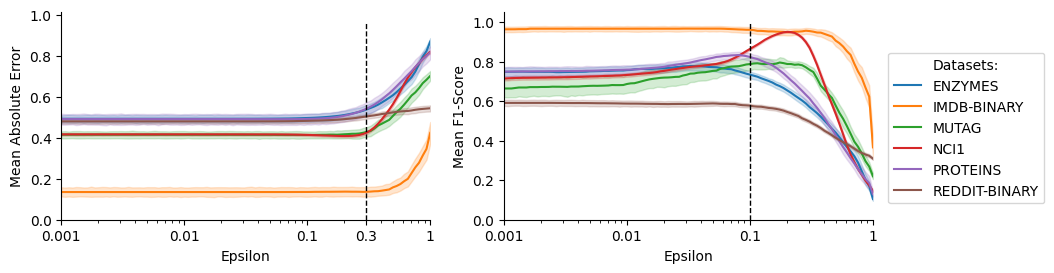

In [802]:
def custom_lineplot(data, x, y, std, **kwargs):
    if kwargs['label'] == "RANDOM":
        kwargs['color'] = 'black'

    line = sns.lineplot(data=data, x=x, y=y, **kwargs)
    #line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'])
    #line.errorbar(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'], )

g = sns.FacetGrid(df_global_error[], hue='dataset', col='type',
                  hue_order=['ENZYMES', 'IMDB-BINARY', 'MUTAG', 'NCI1', 'PROTEINS', 'REDDIT-BINARY'], 
                  aspect=1.5, sharey=False, sharex=False)
g.map_dataframe(custom_lineplot, x='eps', y='value', std='std')
g.add_legend(title='Datasets:', frameon=True)
sns.move_legend(g, "center left", bbox_to_anchor=(0.85, 0.5))

g.set_titles(col_template="", row_template="")
g.set_axis_labels("Epsilon", "Mean Absolute Error")

g.axes[0,0].vlines(0.3, 0.0, df_global_error[df_global_error['type'] == 'error']['value'].max(),
                    colors='black', linestyles='dashed', alpha=1.0, linewidth=1)
g.axes[0, 1].vlines(0.1, 0.0, df_global_error[df_global_error['type'] == 'f1']['value'].max(),
                     colors='black', linestyles='dashed', alpha=1.0, linewidth=1)
g.axes[0,0].set_ylim(0.0, None)

g.axes[0,0].set_xscale('log')
g.axes[0,0].set_xlim(0.001, 1)
g.axes[0,0].set_xticks([0.001, 0.01, 0.1, 0.3, 1])
g.axes[0,0].set_xticklabels(['0.001', '0.01', '0.1', '0.3', '1'])

g.axes[0,1].set_xscale('log')
g.axes[0,1].set_xlim(0.001, 1)
g.axes[0,1].set_xticks([0.001, 0.01, 0.1, 1])
g.axes[0,1].set_xticklabels(['0.001', '0.01', '0.1', '1'])
g.axes[0,1].set_ylabel('Mean F1-Score')
g.axes[0,1].set_ylim(0.0, None)

plt.subplots_adjust(wspace = 0.2)

#g.savefig('../Latex/Figures/global_error.pdf', bbox_inches='tight')

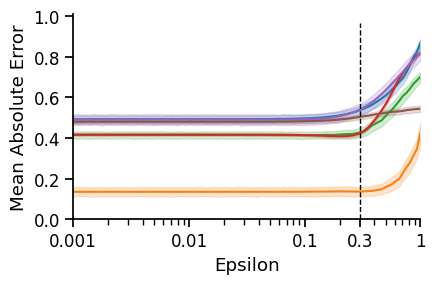

In [827]:
with sns.plotting_context("notebook", font_scale=1.1):

    def custom_lineplot(data, x, y, std, **kwargs):
        if kwargs['label'] == "RANDOM":
            kwargs['color'] = 'black'

        line = sns.lineplot(data=data, x=x, y=y, **kwargs)
        #line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'])
        #line.errorbar(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'], )

    g = sns.FacetGrid(df_global_error[df_global_error['type'] == 'error'], hue='dataset',
                    hue_order=['ENZYMES', 'IMDB-BINARY', 'MUTAG', 'NCI1', 'PROTEINS', 'REDDIT-BINARY'], 
                    aspect=1.5, sharey=False, sharex=False)
    g.map_dataframe(custom_lineplot, x='eps', y='value', std='std')

    #g.add_legend(title='Datasets:', frameon=True)
    #sns.move_legend(g, "center left", bbox_to_anchor=(0.85, 0.5))

    g.set_titles(col_template="", row_template="")
    g.set_axis_labels("Epsilon", "Mean Absolute Error")

    g.axes[0,0].vlines(0.3, 0.0, df_global_error[df_global_error['type'] == 'error']['value'].max(),
                        colors='black', linestyles='dashed', alpha=1.0, linewidth=1)
    # g.axes[0, 1].vlines(0.1, 0.0, df_global_error[df_global_error['type'] == 'f1']['value'].max(),
    #                      colors='black', linestyles='dashed', alpha=1.0, linewidth=1)

    g.axes[0,0].set_ylim(0.0, None)
    g.axes[0,0].set_xscale('log')
    g.axes[0,0].set_xlim(0.001, 1)
    g.axes[0,0].set_xticks([0.001, 0.01, 0.1, 0.3, 1])
    g.axes[0,0].set_xticklabels(['0.001', '0.01', '0.1', '0.3', '1'])

    g.savefig('../Latex/Figures/global_error_1_b.pdf', bbox_inches='tight')

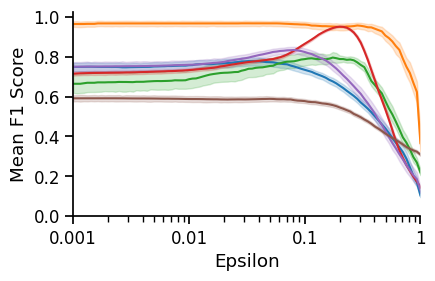

In [828]:
with sns.plotting_context("notebook", font_scale=1.1):

    def custom_lineplot(data, x, y, std, **kwargs):
        if kwargs['label'] == "RANDOM":
            kwargs['color'] = 'black'

        line = sns.lineplot(data=data, x=x, y=y, **kwargs)
        #line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'])
        #line.errorbar(data[x], data[y] - data[std], data[y] + data[std], alpha=0.1, color=kwargs['color'], )

    g = sns.FacetGrid(df_global_error[df_global_error['type'] == 'f1'], hue='dataset',
                    hue_order=['ENZYMES', 'IMDB-BINARY', 'MUTAG', 'NCI1', 'PROTEINS', 'REDDIT-BINARY'], 
                    aspect=1.5, sharey=False, sharex=False)
    g.map_dataframe(custom_lineplot, x='eps', y='value', std='std')

    # g.add_legend(title='Datasets:', frameon=True)
    # sns.move_legend(g, "center left", bbox_to_anchor=(0.85, 0.5))

    g.set_titles(col_template="", row_template="")
    g.set_axis_labels("Epsilon", "Mean F1 Score")

    #g.axes[0,0].vlines(0.1, 0.0, df_global_error[df_global_error['type'] == 'f1']['value'].max(),
    #                   colors='black', linestyles='dashed', alpha=1.0, linewidth=1)
    # g.axes[0, 1].vlines(0.1, 0.0, df_global_error[df_global_error['type'] == 'f1']['value'].max(),
    #                      colors='black', linestyles='dashed', alpha=1.0, linewidth=1)

    g.axes[0,0].set_ylim(0.0, None)
    g.axes[0,0].set_xscale('log')
    g.axes[0,0].set_xlim(0.001, 1)
    g.axes[0,0].set_xticks([0.001, 0.01, 0.1, 1])
    g.axes[0,0].set_xticklabels(['0.001', '0.01', '0.1', '1'])
    g.savefig('../Latex/Figures/global_error_2_log.pdf', bbox_inches='tight')

In [852]:
df_global_error

,eps,type,dataset,value
0,0.001,error,ENZYMES,0.493535
1,0.001,error,ENZYMES,0.419131
2,0.001,error,ENZYMES,0.623982
3,0.001,error,ENZYMES,0.486953
4,0.001,error,ENZYMES,0.615184
...,...,...,...,...
540595,1.000,f1,RANDOM,0.103035
540596,1.000,f1,RANDOM,0.201327
540597,1.000,f1,RANDOM,0.384615
540598,1.000,f1,RANDOM,0.059355


In [864]:
df_global_error.groupby(['dataset', 'type', 'eps']).agg({'value' : 'mean'}).groupby(['type','dataset']).agg({'value' : 'max'})

value
type  dataset                
error ENZYMES        0.869264
      IMDB-BINARY    0.423916
      MUTAG          0.701708
      NCI1           0.819513
      PROTEINS       0.816021
      RANDOM         0.724025
      REDDIT-BINARY  0.543883
f1    ENZYMES        0.778134
      IMDB-BINARY    0.967636
      MUTAG          0.795951
      NCI1           0.951178
      PROTEINS       0.833983
      RANDOM         0.645264
      REDDIT-BINARY  0.591586

In [818]:
import pylab

fig = pylab.figure()

figlegend = pylab.figure(figsize=(3,2))
figlegend.legend(g.axes[0,0].get_legend_handles_labels()[0],
                    g.axes[0,0].get_legend_handles_labels()[1], ncol=1, title='Datasets:')
figlegend.show()
#figlegend.savefig(f'../LaTeX/figures/global_error_legend.pdf', bbox_inches='tight')

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/575598984.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figlegend.show()


<Figure size 640x480 with 0 Axes>

<Figure size 300x200 with 0 Axes>

In [ ]:

eps_values = np.logspace(-3, 0.0, num=1000)

# Normalize X
if X.max() != 0:
    X = X / X.max()


data = []
for eps in eps_values:
    num_removed = 0
    avg_acc = []

    Y_pred = torch.ones_like(Y) * (Y.max() + 1)

    for class_label in Y.unique(sorted=False):

        # Distance matrix between nodes
        sample_indices = torch.argwhere(Y == class_label).squeeze(0)
        X_query = X[sample_indices].reshape(-1, X.shape[1])

        if len(sample_indices) > 1:

            # Calculate pairwise distance matrix
            distance = torch.cdist(X_query, X_query, p=2)

            removed_indices = []
            while True:
                num_points_outside_eps_ball = (distance > eps).count_nonzero(dim=1)

                # If all remaining points are contained in one eps-ball, we terminate
                if (num_points_outside_eps_ball == 0.0).all():
                    break
                
                # Remove the index that is the furthes away from all other points
                index = num_points_outside_eps_ball.argmax()
                distance[index, :] = 0.0
                distance[:, index] = 0.0

                removed_indices.append(index)
            
            avg_acc.append((len(sample_indices) - len(removed_indices)) / len(sample_indices))
            num_removed += len(removed_indices)

            if removed_indices != []:
                removed_indices = sample_indices[torch.tensor(removed_indices)]
                sample_indices = torch.tensor([idx for idx in sample_indices if idx not in removed_indices])
            
        Y_pred[sample_indices] = class_label

    f1 = f1_score(Y, Y_pred, average='macro')
    avg_acc = np.mean(avg_acc)

    data.append({'epsilon': eps, 'f1_score' : round(f1 * 100, 2), 'removed' : num_removed,
                 'avg_acc' : round(avg_acc * 100, 2), 'acc' : round((len(Y) - num_removed) / len(Y) * 100, 2)})

data = pd.DataFrame(data)
data


In [ ]:
from sklearn.metrics import f1_score

eps_values = [0.10, 0.05, 0.01, 0.001]

df_data = pd.DataFrame()
for eps in eps_values:
    data = []
    Y_pred = torch.ones_like(Y) * (Y.max() + 1)

    for class_label in Y.unique(sorted=False):
        # Distance matrix between nodes
        sample_indices = torch.argwhere(Y == class_label).squeeze(0)
        X_query = X[sample_indices].reshape(-1, X.shape[1])

        if len(sample_indices) > 1:

            # Calculate pairwise distance matrix
            distance = torch.cdist(X_query, X_query, p=2)

            removed_indices = []
            while True:
                num_points_outside_eps_ball = (distance > eps).count_nonzero(dim=1)

                # If all remaining points are contained in one eps-ball, we terminate
                if (num_points_outside_eps_ball == 0.0).all():
                    break
                
                # Remove the index that is the furthes away from all other points
                index = num_points_outside_eps_ball.argmax()
                distance[index, :] = 0.0
                distance[:, index] = 0.0

                removed_indices.append(index)

            for idx in range(X.shape[0]):
                if idx in sample_indices and idx not in removed_indices:
                    data.append([idx, class_label])

                elif idx not in sample_indices and \
                    ((torch.cdist(X_query, X[idx].unsqueeze(0), p=2) < eps).count_nonzero(dim=1) == 0).all():
                        
                    data.append([idx, class_label])
            
        else:
            data.append([sample_indices.item(), class_label])
        
    data = torch.tensor(data)

In [ ]:
def calculate_max_accuracy(dataset):
        # Get unique samples in x
        unique_samples, unique_indices = torch.unique(dataset[:, :-1], dim=0, return_inverse=True)

        max_correct = 0
        total_samples = 0

        for i in range(unique_samples.shape[0]):
            # Find indices of matching samples in the dataset. 
            # Necessary to use flatten() to get a 1D tensor such that 'dataset[matching_indices]' returns a 2D tensor.
            matching_indices = torch.nonzero(unique_indices == i, as_tuple=False).flatten()

            # Get matching samples and labels
            matching_samples = dataset[matching_indices]
            matching_labels = matching_samples[:, -1]

            # Count the occurrences of each class label
            _, label_counts = torch.unique(matching_labels, return_counts=True)

            # Update the maximum correct count
            max_correct += torch.max(label_counts)

            # Update the total number of samples
            total_samples += matching_samples.shape[0]

        # Calculate the maximal accuracy
        max_accuracy = max_correct / total_samples
        return max_accuracy

In [ ]:
def facet_heatmap(data, color, **kwargs):
    data = data.pivot(index="i", columns='j', values='distance')
    sns.heatmap(data, cmap='Blues', **kwargs)

index_split = [indices_graphs[:5], indices_graphs[5:]]
for i in range(2):
    data = df_dist_matrix[df_dist_matrix['idx'].isin(index_split[i])]
    g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)

    if i == 0:
        g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
    else:
        cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes
        g.map_dataframe(facet_heatmap, cbar_ax=cbar_ax, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)

    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    
    g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_{i}.png'.format(i), bbox_inches='tight', dpi=600)

In [ ]:
data = df_dist_matrix[df_dist_matrix['idx'] == test_index[torch.randint(0, len(test_index), (1,)).item()]]
g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)
g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
#g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_single.pdf', bbox_inches='tight')

In [ ]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(9, 0.5))
img = pl.imshow(a, cmap="Blues")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
#pl.savefig("../Latex/Figures/colorbar.pdf", bbox_inches='tight')

# Clustering Metric

In [ ]:
from sklearn import metrics

all_metrics = ['rand_score', 'adjusted_rand_score', 'normalized_mutual_info_score', 'adjusted_mutual_info_score',
               'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score']
def evaluate(y_pred, y_true):
    rs = metrics.rand_score(y_true, y_pred)
    ars = metrics.adjusted_rand_score(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_true, y_pred)
    hom = metrics.homogeneity_score(y_true, y_pred)
    com = metrics.completeness_score(y_true, y_pred)
    vms = metrics.v_measure_score(y_true, y_pred)
    fws = metrics.fowlkes_mallows_score(y_true, y_pred)


    return {'rand_score': rs, 'adjusted_rand_score': ars, 'normalized_mutual_info_score': nmi,
            'adjusted_mutual_info_score': ami, 'homogeneity_score': hom, 'completeness_score': com,
            'v_measure_score': vms, 'fowlkes_mallows_score': fws}

In [ ]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch, BisectingKMeans
dist_data = []
num_cluster = len(torch.unique(y_test))

kmeans = KMeans(n_clusters=num_cluster, random_state=42, init='k-means++', n_init='auto').fit(x_test)
dist_data.append(evaluate(kmeans.labels_, y_test) | {'name': 'kmeans', 'num_cluster': num_cluster})

aggC_ward = AgglomerativeClustering(n_clusters=num_cluster, linkage='ward').fit(x_test)
dist_data.append(evaluate(aggC_ward.labels_, y_test) | {'name': 'aggC_ward', 'num_cluster': num_cluster})

aggC_avg = AgglomerativeClustering(n_clusters=num_cluster, linkage='average').fit(x_test)
dist_data.append(evaluate(aggC_avg.labels_, y_test) | {'name': 'aggC_avg', 'num_cluster': num_cluster})

dbscan = DBSCAN(eps=0.5, min_samples=5).fit(x_test)
dist_data.append(evaluate(dbscan.labels_, y_test) | {'name': 'dbscan', 'num_cluster': num_cluster})

optics = OPTICS(min_samples=5).fit(x_test)
dist_data.append(evaluate(optics.labels_, y_test) | {'name': 'optics', 'num_cluster': num_cluster})

birch = Birch(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(birch.labels_, y_test) | {'name': 'birch', 'num_cluster': num_cluster})

bisectingKmeans = BisectingKMeans(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(bisectingKmeans.labels_, y_test) | {'name': 'bisectingKmeans', 'num_cluster': num_cluster})

df_cluster_metrics = pd.DataFrame(dist_data)

In [ ]:
df_cluster_metrics

In [ ]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_gnn = model.pool(x_gnn, dataset[idx].batch)
        x_wl = dataset[idx].y

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_gnn = model.pool(x_gnn, dataset[idx].batch)
        x_wl = dataset[idx].y

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

# KNN

In [ ]:
knn_runs = ['o84jwl99', 'r0hzi69w', 'hsoebyq6', 'h41v1r4j', '9c64l23v', 'ircwl3vt',
            'xwp3x7vc', 'nor2tequ', 'vvw0t1se', 'tku7invn', 'abuwjdwl', 's86vy9xe' ]

df_knn = pd.DataFrame()
api = wandb.Api()
runs = api.runs("eric-bill/BachelorThesisExperiments")

for run in runs:
    if run.state == "finished" and run.id in knn_runs:

        knn = run.history(keys=['k', 'knn_accuracies', 'knn_accuracies_std'])
        knn['dataset'] = run.config['dataset']
        knn['model_type'] = get_model_type(run.config['model'])
        knn['test_accuracy'] = run.summary['test_accuracy']
        knn['run_id'] = run.id

        df_knn = pd.concat([df_knn, knn], ignore_index=True)

df_knn

In [30]:
pivot_knn = get_acc_and_std(df_knn, group_col=['model_type','dataset'], acc_col='knn_accuracies', std_col='knn_accuracies_std', latex=True, reg=False)
pivot_knn.pivot_table(index=['model_type'], columns=['dataset'], values=['knn_accuracies'], aggfunc=lambda x: x)

knn_accuracies                              \
dataset                        ENZYMES                 IMDB-BINARY   
model_type                                                           
1-WL+NN     56.3 \scriptsize $\pm 5.8$  72.3 \scriptsize $\pm 4.1$   
GNN         51.6 \scriptsize $\pm 7.0$  74.3 \scriptsize $\pm 4.0$   

                                                                    \
dataset                          MUTAG                        NCI1   
model_type                                                           
1-WL+NN     86.7 \scriptsize $\pm 7.7$  83.9 \scriptsize $\pm 1.8$   
GNN         88.3 \scriptsize $\pm 6.5$  77.5 \scriptsize $\pm 1.7$   

                                                                    
dataset                       PROTEINS               REDDIT-BINARY  
model_type                                                          
1-WL+NN     73.9 \scriptsize $\pm 4.1$  83.2 \scriptsize $\pm 2.5$  
GNN         74.9 \scriptsize $\pm 4.3$  90.8 \scriptsize $\pm 1.8$

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_10780/534071222.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])


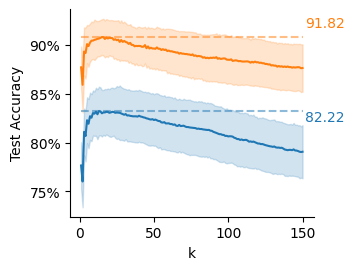

In [32]:
def plot_knn(data, x, y, std, **kwargs):
    y_max = data[y].max()
    data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    sns.lineplot(data_max, x=x, y='max', color=kwargs['color'], alpha=0.5, linestyle='--')

    line = sns.lineplot(data=data, x=x, y=y, **kwargs)

    # Fix if the text is to close togehter
    if y_max < 88.3:
        y_max -= 1
    else:
        y_max += 1
    
    line.axes.text(data[x].max() + 2, y_max, f"{round(y_max, 2)}", color=kwargs['color'])
    line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.2, color=kwargs['color'])

    # y_max = data['test_accuracy'].max()
    # data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    # sns.lineplot(data_max, x=x, y='max', color='black', alpha=0.5, linestyle='-')
    # line.axes.text(data[x].max() + 2, y_max, f"{round(y_max, 2)}")

for dataset_name in ['REDDIT-BINARY']:#df_knn.dataset.unique():

    g = sns.FacetGrid(df_knn[df_knn['dataset'] == dataset_name], col='dataset', hue='model_type', col_wrap=3, hue_order=['1-WL+NN', 'GNN'], margin_titles=True, sharex=False, sharey=False)
    g.map_dataframe(plot_knn, x='k', y='knn_accuracies', std='knn_accuracies_std', legend=None)
    #g.add_legend(frameon=True)
    g.set_titles(col_template="", row_template="")
    g.set_axis_labels("k", "Test Accuracy")
    g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])

    #sns.move_legend(g, "center right", bbox_to_anchor=(1.05, 0.5), title='Model Types')

    g.savefig(f'../LaTeX/Figures/knn_{dataset_name}.pdf', bbox_inches='tight')
    plt.show()

# SVM Viz

In [33]:
dataset_name = 'REDDIT'

wlnn_name = "1-WL+NN: 86.4% Accuracy"
gnn_name = "GNN: 51.9% Accuracy"
model = torch.load(f'saved_models/GNN_{dataset_name}.pt')

In [34]:
def calc_svm_boundary_contour(X, Y, n_points=5, **kwargs):
    clf = SVC(kernel='linear', **kwargs)
    clf.fit(X, Y)

    # Create a grid of points
    x_min = np.min(X.T, axis=1)
    x_max = np.max(X.T, axis=1)
    h = (x_max - x_min) / n_points

    arr_arange = [np.arange(x_min[i], x_max[i], h[i]) for i in range(len(x_min))]
    xx = np.meshgrid(*arr_arange)
    xx = np.hstack([dim.reshape(-1, 1) for dim in np.meshgrid(*arr_arange)])

    # Calculate the decision values for the grid points
    Z = clf.predict(xx)
        
    return pd.DataFrame({'x': xx[:, 0], 'y': xx[:, 1], 'class': Z})

In [35]:
model_gnn = torch.load(f'saved_models/GNN_{dataset_name}.pt')
X_gnn = model_gnn.data_aggregate[:, :-1]
Y_gnn = model_gnn.data_aggregate[:, -1]

X_gnn = TSNE(n_components=2).fit_transform(X_gnn)

df_gnn = pd.DataFrame(X_gnn, columns=['x', 'y'])
df_gnn['class'] = Y_gnn
df_gnn['model_type'] = gnn_name
df_gnn['scatter'] = 1

df_svm = calc_svm_boundary_contour(X_gnn, Y_gnn, n_points=100)
df_svm['model_type'] = gnn_name
df_svm['scatter'] = 0

df_gnn = pd.concat([df_gnn, df_svm])

model_wlnn = torch.load(f'saved_models/WLNN_{dataset_name}.pt')
X_wlnn = model_wlnn.data_aggregate[:, :-1]
Y_wlnn = model_wlnn.data_aggregate[:, -1]

X_wlnn = TSNE(n_components=2).fit_transform(X_wlnn)

df_wlnn = pd.DataFrame(X_wlnn, columns=['x', 'y'])
df_wlnn['class'] = Y_wlnn
df_wlnn['model_type'] = wlnn_name
df_wlnn['scatter'] = 1

df_svm = calc_svm_boundary_contour(X_wlnn, Y_wlnn, n_points=100)
df_svm['model_type'] = wlnn_name
df_svm['scatter'] = 0

df_wlnn = pd.concat([df_wlnn, df_svm])

df_svm = pd.concat([df_gnn, df_wlnn])

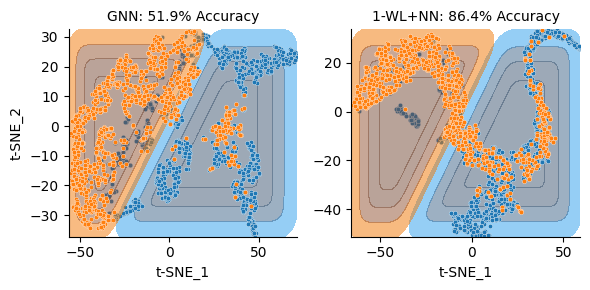

In [37]:
def custom_plotter(data, x, y, **kwargs):
    sns.kdeplot(data=data[data['scatter'] == 0], x=x, y=y, levels=5, alpha=0.5, fill=True, thresh=0.1, **kwargs)
    sns.scatterplot(data=data[data['scatter'] == 1], x=x, y=y, s=10, **kwargs)

g = sns.FacetGrid(df_svm, col='model_type', hue='class', margin_titles=True, sharex=False, sharey=False)
g.map_dataframe(custom_plotter, x='x', y='y')

g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f't-SNE_1', f't-SNE_2')

x_min_gnn, y_min_gnn = df_svm[df_svm['model_type'] == gnn_name][['x', 'y']].min()
x_max_gnn, y_max_gnn = df_svm[df_svm['model_type'] == gnn_name][['x', 'y']].max()

g.axes[0, 0].set_xlim(x_min_gnn, x_max_gnn)
g.axes[0, 0].set_ylim(y_min_gnn, y_max_gnn)

x_min_wlnn, y_min_wlnn = df_svm[df_svm['model_type'] == wlnn_name][['x', 'y']].min()
x_max_wlnn, y_max_wlnn = df_svm[df_svm['model_type'] == wlnn_name][['x', 'y']].max()
g.axes[0, 1].set_xlim(x_min_wlnn, x_max_wlnn)
g.axes[0, 1].set_ylim(y_min_wlnn, y_max_wlnn)

g.savefig(f'../LaTeX/figures/tsne_svm_lin_{dataset_name}.pdf', bbox_inches='tight')

# Quantil

In [ ]:
def calc_quantil_performance(dataframe, grouping_columns, quantils):
    rows = []

    for (grouping_values, grouped_dataframe) in dataframe.groupby(grouping_columns):
        for q in quantils:
            index = grouped_dataframe.index[grouped_dataframe['test_accuracy'] >= grouped_dataframe['test_accuracy'].quantile(1 - q, interpolation='lower')]
            grouping_info = {column: value for column, value in zip(grouping_columns, grouping_values)}
            
            for i in index:
                rows.append({'Quantile' : f'{int(q*100)}%', 'train_accuracy' : dataframe.loc[i]['train_accuracy'],
                             'val_accuracy' : dataframe.loc[i]['val_accuracy'], 'test_accuracy' : dataframe.loc[i]['test_accuracy'],
                            } | grouping_info)

    return pd.DataFrame(rows)

In [ ]:
df_qunatil = calc_quantil_performance(runs_df, ['dataset', 'model_type'], quantils=[0.01, 0.05, 0.10, 0.25, 0.5, 1.0])
df_qunatil['difference'] = df_qunatil['train_accuracy'] - df_qunatil['test_accuracy']

In [ ]:
with sns.plotting_context("notebook", font_scale=1.3):
    for dataset_name in df_qunatil['dataset'].unique():
        df = df_qunatil[df_qunatil['dataset'] == dataset_name]

        ax = sns.barplot(df, x='Quantile', y='difference', hue='model_type', hue_order=['1-WL+NN', 'GNN'], estimator='mean', errorbar='se', saturation=1.0)
        sns.despine(bottom = False, left = False)

        #bar.set_title('Absolute Difference in Classification Accuracies between Training and Testing')
        ax.set_ylabel('Train Acc. - Test Acc.')

        y_max = df[['difference', 'Quantile', 'model_type']].groupby(['Quantile', 'model_type']).mean().max().abs().item()
        y_min = df[['difference', 'Quantile', 'model_type']].groupby(['Quantile', 'model_type']).mean().min().item()

        if y_min > 0:
            y_min = - 0.2 * y_max

        ax.set_ylim([1.1* y_min, 1.1 * y_max])

        if dataset_name == 'MUTAG' or dataset_name == 'REDDIT-BINARY':
            ax.set_yticks([int(y_min)] + ax.get_yticks()[1:])

        ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])

        ax.axhline(0.0, color='black', linestyle='--', alpha=0.5, snap=True)
        ax.legend_.remove()

        fig = ax.get_figure()
        #fig.savefig(f'../LaTeX/figures/train_test_diff_{dataset_name}.pdf', bbox_inches='tight')

        plt.show()

In [ ]:
import pylab

fig = pylab.figure()

figlegend = pylab.figure(figsize=(3,2))
figlegend.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], ncol=2)
figlegend.show()
#figlegend.savefig(f'../LaTeX/figures/train_test_diff_legend.pdf', bbox_inches='tight')


In [ ]:
df_qunatil = calc_quantil_performance(runs_df[(runs_df['model_type'] == '1-WL+NN') & (runs_df['k_wl'] > 0)], ['dataset', 'k_wl'], quantils=[0.01, 0.05, 0.10, 0.25, 0.5, 1.0])
df_qunatil['difference'] = df_qunatil['train_accuracy'] - df_qunatil['test_accuracy']

In [ ]:
with sns.plotting_context("notebook", font_scale=1.3):
    for dataset_name in df_qunatil['dataset'].unique():
        df = df_qunatil[df_qunatil['dataset'] == dataset_name]

        ax = sns.barplot(df, x='Quantile', y='difference', hue='k_wl', hue_order=[1, 2, 3, 4], estimator='mean', errorbar='se', saturation=1.0)
        sns.despine(bottom = False, left = False)

        #bar.set_title('Absolute Difference in Classification Accuracies between Training and Testing')
        ax.set_ylabel('Train Acc. - Test Acc.')

        y_max = df[['difference', 'Quantile', 'k_wl']].groupby(['Quantile', 'k_wl']).mean().max().abs().item()
        y_min = df[['difference', 'Quantile', 'k_wl']].groupby(['Quantile', 'k_wl']).mean().min().item()

        y_min = - 0.2 * y_max
        ax.set_ylim([1.1* y_min, 1.1 * y_max])

        if dataset_name == 'IMDB-BINARY':
            ax.set_yticks([int(y_min)] + ax.get_yticks()[1:])

        ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])

        ax.axhline(0.0, color='black', linestyle='--', alpha=0.5, snap=True)
        ax.legend_.remove()

        fig = ax.get_figure()
        #fig.savefig(f'../LaTeX/figures/train_test_diff_k_wl_{dataset_name}.pdf', bbox_inches='tight')

        print(f'Dataset: {dataset_name}')
        plt.show()

        

In [ ]:
import pylab

fig = pylab.figure()

figlegend = pylab.figure(figsize=(3,2))
figlegend.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], ncol=4, title='1-WL Iterations:')
figlegend.show()
figlegend.savefig(f'../LaTeX/figures/train_test_diff_k_wl_legend.pdf', bbox_inches='tight')

# Unbalanceness

In [ ]:
dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name="PROTEINS").shuffle()
dataset.y.unique(sorted=False, return_counts=True)

In [ ]:
dataset_list = ["ENZYMES", "PROTEINS", "IMDB-BINARY", "IMDB-MULTI", "NCI1", "MUTAG", "REDDIT-BINARY", "REDDIT-MULTI-5K"]

data = []
for dataset_name in dataset_list:
    dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name=dataset_name).shuffle()
    unbalance = utils.calc_shannon_diversity(dataset)
    data.append([dataset_name, unbalance])

clear_output()
df_unbalances = pd.DataFrame(data, columns=["dataset", "shannon_diversity"])
df_unbalances.pivot_table(columns="dataset", values="shannon_diversity")

In [ ]:
api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

dist_data = []
for run in runs:
    if run.state == "finished" and ': Theoretical Accuracy' in run.name:
        history = run.history()
        history.sort_values(by='k_wl', ascending=True, inplace=True)

        row = f'& {run.config["dataset"]} '
        last_acc = 0.0
        for acc in history['max_acc']:
            if acc > last_acc:
                row += f'& {acc:.2f} '
            else:
                row += f'& - '
            last_acc = acc
        row += '\\\\'
        print(row)

# Number of 1-WL Iterations Dependency

Dataset: REDDIT-BINARY


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


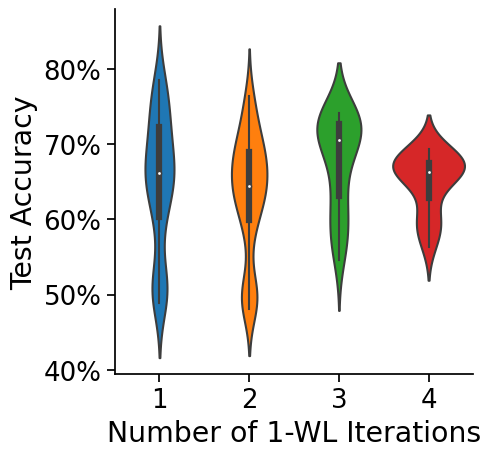

Dataset: ENZYMES


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


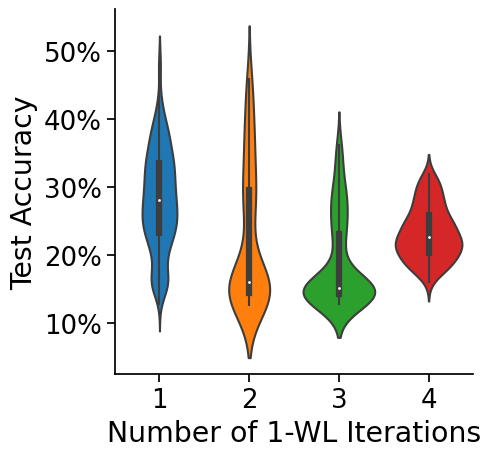

Dataset: MUTAG


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


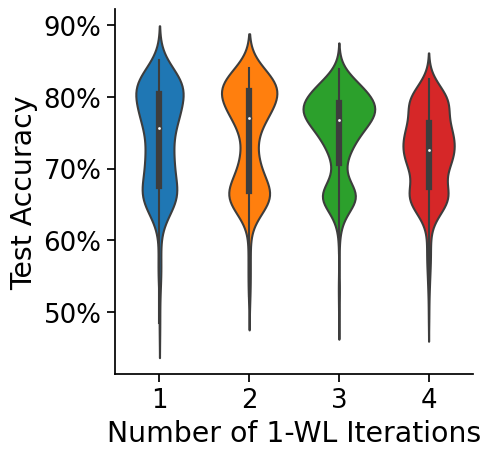

Dataset: NCI1


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


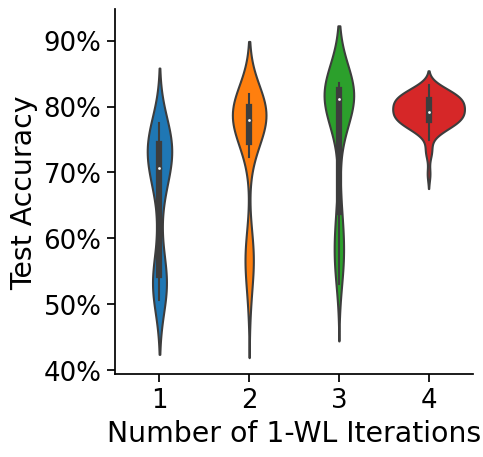

Dataset: PROTEINS


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


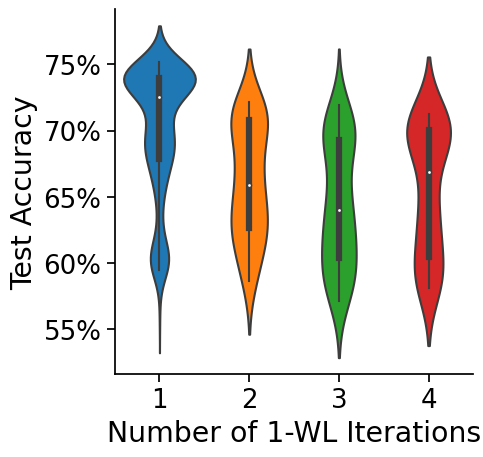

Dataset: IMDB-BINARY


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/1101166230.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])


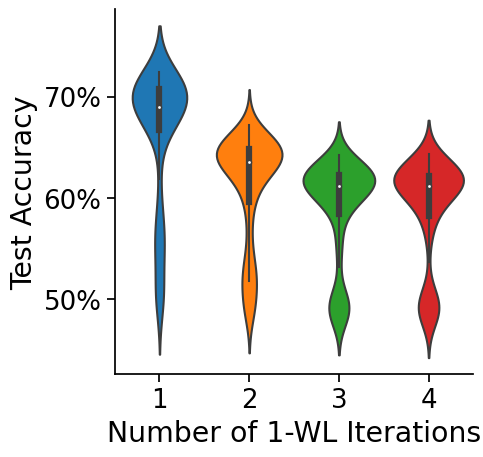

In [844]:
k_wl_df = runs_df[runs_df['model_type'] == '1-WL+NN'][['k_wl', 'dataset', 'test_accuracy']].reset_index()
k_wl_df['k_wl'] = k_wl_df['k_wl'].astype(int)
k_wl_df = k_wl_df[k_wl_df['k_wl'] > -1]
k_wl_df.dropna(inplace=True)

with sns.plotting_context("notebook", font_scale=1.7):

    for ds in k_wl_df['dataset'].unique():
        print(f'Dataset: {ds}')

        g = sns.catplot(data=k_wl_df[k_wl_df['dataset'] == ds], y='test_accuracy', x='k_wl', kind='violin', alpha=1.0, saturation=1.0)
        g.set_titles('{col_name}')
        g.set_ylabels('Test Accuracy')
        g.set_xlabels('Number of 1-WL Iterations')
        g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])
        plt.show()

        g.savefig(f'../LaTeX/figures/k_wl_violin_{ds}.pdf', bbox_inches='tight')

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/995759597.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}' for y in g.axes[0, 0].get_yticks()])


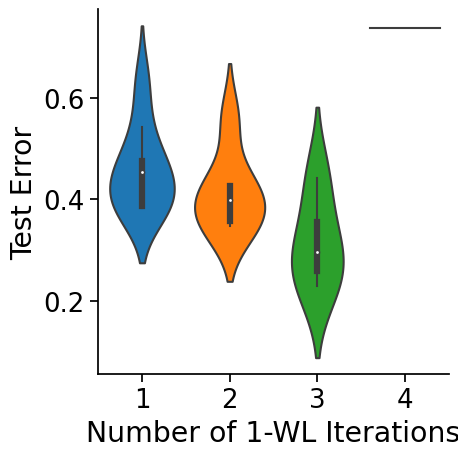

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/995759597.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}' for y in g.axes[0, 0].get_yticks()])


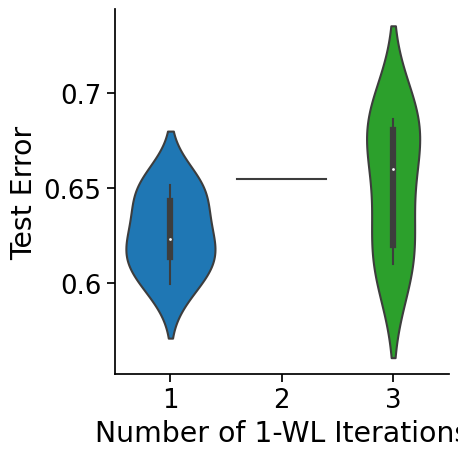

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/995759597.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}' for y in g.axes[0, 0].get_yticks()])


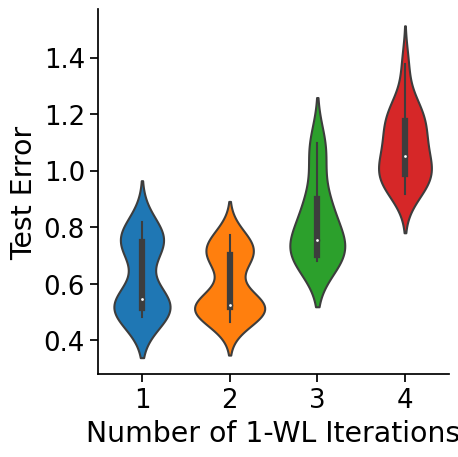

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_43638/995759597.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}' for y in g.axes[0, 0].get_yticks()])


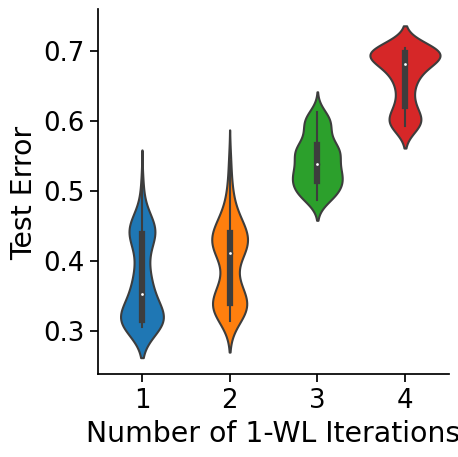

In [845]:
k_wl_df = runs_df[runs_df['model_type'] == '1-WL+NN'][['k_wl', 'dataset', 'test_error']].reset_index()
k_wl_df['k_wl'] = k_wl_df['k_wl'].astype(int)
k_wl_df.dropna(inplace=True)

with sns.plotting_context("notebook", font_scale=1.7):

    for ds in k_wl_df['dataset'].unique():
        g = sns.catplot(data=k_wl_df[k_wl_df['dataset'] == ds], y='test_error', x='k_wl', kind='violin', alpha=1.0, saturation=1.0)
        g.set_titles('{col_name}')
        g.set_ylabels('Test Error')
        g.set_xlabels('Number of 1-WL Iterations')
        g.axes[0, 0].set_yticklabels([f'{round(y, 2)}' for y in g.axes[0, 0].get_yticks()])
        plt.show()

        g.savefig(f'../LaTeX/figures/k_wl_violin_{ds}.pdf', bbox_inches='tight')

# Unique Colors

In [ ]:
dataset = TUDataset(root=f"datasets", name="ENZYMES")

In [ ]:
dataset.len()

In [ ]:
from torch_geometric.datasets import TUDataset
from utils import Wrapper_WL_TUDataset
from utils import Constant_Long

dataset_name = ['ENZYMES', 'PROTEINS', 'IMDB-BINARY','NCI1', 'MUTAG', 'REDDIT-BINARY']
dataset_name.sort()

data = []

for ds in dataset_name:
    print(f'Dataset: {ds}')
    dataset = TUDataset(root=f"datasets", name=ds)
    
    if dataset._data.x is None:
        dataset.transform = Constant_Long(0)

    wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=-1, wl_convergence=True)


In [ ]:
from torch_geometric.datasets import TUDataset
from utils import Wrapper_WL_TUDataset
from utils import Constant_Long

dataset_name = ['ENZYMES', 'PROTEINS', 'IMDB-BINARY','NCI1', 'MUTAG', 'REDDIT-BINARY']
dataset_name.sort()

data = []

for ds in dataset_name:
    dataset = TUDataset(root=f"datasets", name=ds)

    if dataset._data.x is None:
        dataset.transform = Constant_Long(0)

    for k in range(11):
        wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=k, wl_convergence=False)
        unique = wl_dataset.x.unique(sorted=False).shape[0]
        total = wl_dataset.x.shape[0]

        data.append({'dataset' :  ds, 'unique' : unique, 'total' : total, 'ratio' : unique / total, 'k_wl' : k})

df_colors = pd.DataFrame(data)

In [ ]:
sns.reset_defaults()
# sns.set(font_scale=1.0)
# sns.set_style(style='white')
# sns.set_style(rc={'axes.saturation' : 1.0, 'text.usetex' : True})

g = sns.FacetGrid(data=df_colors, hue='dataset', legend_out=True, aspect=1.5)
g.map(sns.lineplot, 'k_wl', 'ratio')
g.map(sns.scatterplot, 'k_wl', 'ratio')

g.add_legend(title='Datasets:', frameon=True)
sns.move_legend(g, "center left", bbox_to_anchor=(1.175, 0.5))

g.map(sns.scatterplot, x=[0], y=[-0.05], alpha=0.0)

g.set_ylabels('Ratio of Unique Colors')
g.set_xlabels('Number of 1-WL Iterations')

g.set(xticks=np.arange(0,11,1), yticks=np.arange(0,1.1,0.2))

axins = g.axes[0, 0].inset_axes([1.2, 0.5, 0.47, 0.47])
sns.lineplot(data=df_colors, x='k_wl', y='ratio', hue='dataset', ax=axins)
sns.scatterplot(data=df_colors, x='k_wl', y='ratio', hue='dataset'
                , ax=axins)

axins.legend_.remove()

axins.set_xlim(0.5, 3.5)
axins.set_ylim(-0.05, 0.4)
axins.set_yticks(np.arange(0,0.41,0.1))

g.axes[0, 0].indicate_inset_zoom(axins, edgecolor="black", alpha=0.3)

#g.savefig(f'../LaTeX/figures/wl_unique_colors.pdf', bbox_inches='tight')

In [ ]:
df_colors.pivot_table(index='dataset', columns='k_wl', values='unique').to_latex(f'wl_unique_colors.tex', float_format="%.2f")

In [ ]:
df_colors.pivot_table(index='dataset', values='total')

In [ ]:
model = torch.load(f'saved_models/WLNN_{dataset_name}.pt')